Fitting model with sd=10...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 403 seconds.


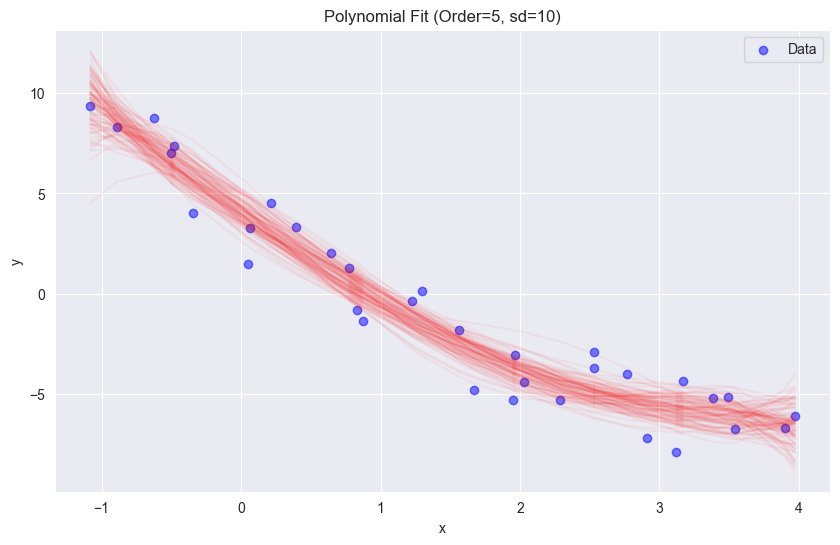


Fitting model with sd=100...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 445 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


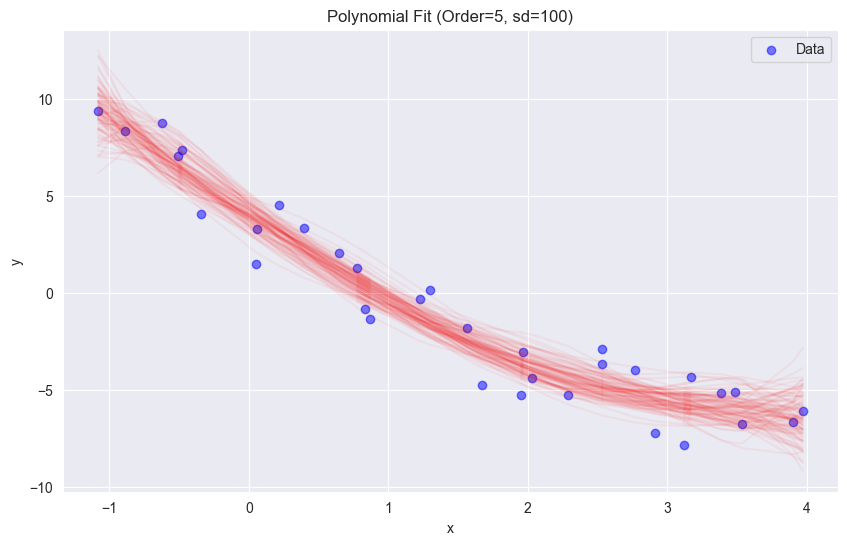


Fitting model with varying sd...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ε]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 56 seconds.


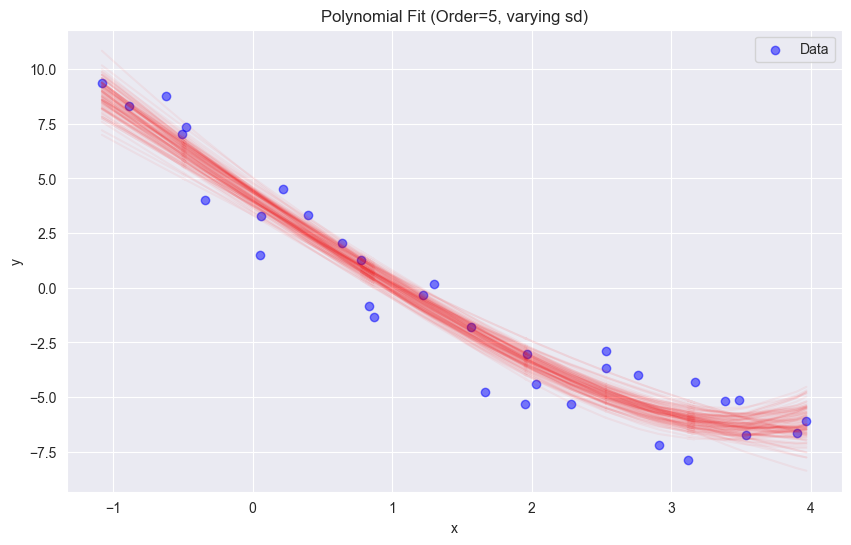


Summary for sd=10:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    -0.000  0.050  -0.092    0.096      0.001    0.001    5426.0    4729.0   
β[0] -1.434  0.254  -1.916   -0.952      0.005    0.004    2456.0    3547.0   
β[1]  0.241  0.654  -1.004    1.444      0.010    0.008    4112.0    4314.0   
β[2]  0.265  2.650  -4.475    5.482      0.057    0.040    2170.0    3185.0   
β[3]  0.448  4.475  -8.362    8.505      0.097    0.069    2122.0    3169.0   
β[4] -0.416  2.291  -4.532    4.126      0.048    0.034    2263.0    3538.0   

      r_hat  
α       1.0  
β[0]    1.0  
β[1]    1.0  
β[2]    1.0  
β[3]    1.0  
β[4]    1.0  

Summary for sd=100:
       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
α    -0.002  0.051  -0.094    0.092      0.001    0.001    4656.0    3794.0   
β[0] -1.444  0.289  -1.989   -0.892      0.006    0.004    2784.0    3002.0   
β[1]  0.244  0.642  -0.975    1.427      0.009    0.007    5042.0    4

In [12]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

# Load and prepare data
data = np.loadtxt('date.csv')
x_1 = data[:, 0]
y_1 = data[:, 1]

def create_polynomial_features(x, order):
    x_1p = np.vstack([x**i for i in range(1, order+1)])
    x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
    return x_1s.T

def fit_polynomial(x, y, order, beta_sd):
    x_1s = create_polynomial_features(x, order)
    y_1s = (y - y.mean()) / y.std()
    
    with pm.Model() as model_p:
        # Priors
        α = pm.Normal('α', mu=0, sigma=1)
        β = pm.Normal('β', mu=0, sigma=beta_sd, shape=order)
        ε = pm.HalfNormal('ε', 5)
        
        # Model
        μ = α + pm.math.dot(x_1s, β)
        y_pred = pm.Normal('y_pred', mu=μ, sigma=ε, observed=y_1s)
        
        # Inference with adjusted parameters
        trace_p = pm.sample(
            2000,
            return_inferencedata=True
        )
    
    return trace_p, model_p

def plot_polynomial_fit(x, y, trace, model, title):
    plt.figure(figsize=(10, 6))
    
    # Plot original data
    plt.scatter(x, y, color='blue', alpha=0.5, label='Data')
    
    # Generate predictions using the same x points as the data
    x_new = x  # Use original x points to avoid dimension mismatch
    x_new_s = create_polynomial_features(x_new, order)
    
    # Get posterior samples
    α_samples = trace.posterior['α'].values.flatten()
    β_samples = trace.posterior['β'].values.reshape(-1, order)
    
    # Plot posterior predictions
    for i in range(100):
        idx = np.random.randint(len(α_samples))
        y_pred = α_samples[idx] + np.dot(x_new_s, β_samples[idx])
        y_pred = y_pred * y.std() + y.mean()
        plt.plot(x_new, y_pred, color='red', alpha=0.05)
    
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set order and fit both models
order = 5

# Fit model with sd=10
print("Fitting model with sd=10...")
trace_10, model_10 = fit_polynomial(x_1, y_1, order, 10)
plot_polynomial_fit(x_1, y_1, trace_10, model_10, f'Polynomial Fit (Order={order}, sd=10)')

# Fit model with sd=100
print("\nFitting model with sd=100...")
trace_100, model_100 = fit_polynomial(x_1, y_1, order, 100)
plot_polynomial_fit(x_1, y_1, trace_100, model_100, f'Polynomial Fit (Order={order}, sd=100)')

# Fit model with varying sd
print("\nFitting model with varying sd...")
varying_sd = np.array([10, 0.1, 0.1, 0.1, 0.1])
trace_varying, model_varying = fit_polynomial(x_1, y_1, order, varying_sd)
plot_polynomial_fit(x_1, y_1, trace_varying, model_varying, f'Polynomial Fit (Order={order}, varying sd)')

# Print summary statistics
for name, trace in [("sd=10", trace_10), ("sd=100", trace_100), ("varying sd", trace_varying)]:
    print(f"\nSummary for {name}:")
    print(az.summary(trace, var_names=['α', 'β']))